In [318]:
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from myutils import *  # restore(), get_filename()
import ptrReader
import pytools as pt
#from particle_tracer import sample_evdf         # CAUSES AN ERROR? seemingly related to the argument parser
from copy import deepcopy
#import os
#os.environ['PATH'] = "/wrk-vakka/group/spacephysics/proj/appl/tex-basic/texlive/2023/bin/x86_64-linux:" + os.environ['PATH']
#print(os.environ["PATH"])

R_EARTH = 6.371e6




In [319]:
# copied directly from utils/particle_tracer.py, because importing didn't work

def sample_evdf(vlsvReader, x, v):
    '''
    given a vlsvReader object, find the value of the distribution function f
    at a given coordinate in position/velocity phase space: f(x,v)
    assumes a maxwellian f, and polytropic equation of state (adiabatic index 5/3)

    Inputs:
    x: position vector [m], 3-element array
    v: velocity vector [m/s], 3-element array
    '''
    gamma = 5. / 3.
    if vlsvReader.get_config() is None:
        # Generally, it should be possible to find parameters with vlsvReader.get_config().
        # Tested: FHA works, but not EGL
        n0 = 1e6              # EGI, EGL, FHA [m^-3]. 
        T0 = 1.380649e-23 * 5e5         # EGI, EGL [Joules]
        vbulk = np.array([-7.5e5, 0, 0])
    else:
        n0 = float(vlsvReader.get_config()['proton_Magnetosphere']['rho'][0])
        T0 = 1.380649e-23 * float(f.get_config()['proton_Magnetosphere']['T'][0])
        vbulk = np.array([f.get_config()['proton_Magnetosphere']['VX0'][0],
                          f.get_config()['proton_Magnetosphere']['VY0'][0],
                          f.get_config()['proton_Magnetosphere']['VZ0'][0]])
    C = T0 * n0**(1. - gamma)
    v_plasma = v - vbulk  # velocity vector in plasma frame
    v_mag = np.sqrt( v_plasma[0]**2 + v_plasma[1]**2 + v_plasma[2]**2 )
    m_e = 9.10938e-31
    '''
    # interpolate to the plasma parameters at the final position
    n = vlsvReader.read_interpolated_variable('proton/vg_rho', x)
    T = C * n**(gamma - 1.)
    vbulk = vlsvReader.read_interpolated_variable('proton/vg_v', x)
    f = n * (m_e / (2 * np.pi * T))**1.5 * np.exp(-m_e * v_mag**2 / (2 * T))
    '''
    f = n0 * (m_e / (2 * np.pi * T0))**1.5 * np.exp(-m_e * v_mag**2 / (2 * T0))
    return f




In [320]:
# Read Lorentziator simulation data, from range of times

def read_lorentziator_ptr_as_dct(ptrdir, metadata_file):
    '''
    path [str]: path to ptr files 
        example: '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1188_x13RE/'
    metadata_file [str]: the .pck file describing the velocity grid, time step, etc.
        example: '{ptrdir}/metadata.pck'
    '''
    import ptrReader

    mdct = restore(metadata_file)
    nv = mdct['nv']
    vmin = mdct['vmin']
    vmax = mdct['vmax']
    dv = (vmax - vmin) / (nv-1.)
    run = mdct['run']
    fileIndex = mdct['fileIndex']
    vpar, vperp = np.meshgrid( np.arange(vmin, vmax+dv, dv), np.arange(vmin,vmax+dv, dv), indexing='ij')
    t = mdct['t']
    start_ti = 0
    #end_ti = nt - 1
    #nt = t.size
    end_ti = 300              # for testing, with fewer files
    nt = end_ti - start_ti + 1   # ''

    xl = np.zeros([nv, nv, nt, 3])
    vl = np.zeros([nv, nv, nt, 3])

    nt_actual=0
    for ti in range(start_ti, end_ti+1):
        try:
            print(ti)
            p = ptrReader.read_ptr_file('{}population.{}.ptr'.format(ptrdir, str(ti).zfill(7)))
            xl[:,:,ti,:] = p.pos().reshape([nv,nv,3])   # shape (nv^2, 3) -> (nv,nv,3)
            vl[:,:,ti,:] = p.vel().reshape([nv,nv,3])   # shape (nv^2, 3) -> (nv,nv,3)
            nt_actual+=1
        except:
            print('index {} does not exist'.format(ti))

    xl = xl[:,:,0:nt_actual,:]
    vl = vl[:,:,0:nt_actual,:]
    t=t[0:nt_actual]

    x_i = xl[:,:,0,:]
    v_i = vl[:,:,0,:]
    x_f = xl[:,:,-1,:]
    v_f = vl[:,:,-1,:]

    # Liouville map the final positions
    f = np.zeros(vpar.shape)
    filename = get_vlsvfile_fullpath(run, fileIndex)
    vlsvReader = pt.vlsvfile.VlsvReader(filename)
    for i in range(nv):
        print('i = {}/{}'.format(i, nv))
        for j in range(nv):
            f[i,j] = sample_evdf(vlsvReader, x_f[i, j, :], v_f[i, j, :])

    dct = { 'f':f, 'vpar':vpar, 'vperp':vperp, 'x_i':x_i, 'v_i': v_i, 'x_f': x_f, 'v_f': v_f, 'x':xl, 'v':vl, 't':t, 'filename':filename,
           'run': run, 'fileIndex': fileIndex, 'nv': nv}

    return dct




In [321]:
# READ DATA (particle_tracer.py or lorentziator)

# === particle_tracer.py ====

'''
run = 'EGI'   # 'EGL'
nv = 8
fileIndex = 1506

##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x10.5_y0.0_z0.0.pickle")
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.0_y0.0_z0.0.pickle")
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.5_y0.0_z0.0.pickle")  # vmax = 1e7
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.5_y1.0_z0.0.pickle")
#d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_80000_x11.5_y0.0_z0.0.pickle")  # vmax = 5e6 (zoomed in)

# v HAVEN'T CHECKED OUT THIS FILE YET v
#fileIndex = 1199
#d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1199_electron_nt_22000_x13.0_y0.0_z0.0.pickle")  # vmax = 2e7
'''


# === lorentziator (.ptr output files) ====

#ptrdir ='/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1188_x13RE/'   # vmax = 2e7
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x13RE/'   # vmax = 5e6
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x11.5RE/'   # vmax = 5e6
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1505.5_1450_x11.5_gpu_tol100/' # vmax = 2e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_100/'   
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1505.5_1450_x11.5_gpu_tol10/' # vmax = 2e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_10/'   
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1500_1200_Nv256_x13_gpu/' # vmax = 1e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_10/'   
ptrdir = '/wrk-vakka/users/kpapadak/lorentziator/test_configs/' # vmax = 1e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_10/'   

metadata_file = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1500_1200_Nv256_x13_gpu/metadata.pck'
#metadata_file = ptrdir + 'metadata.pck'


d = read_lorentziator_ptr_as_dct(ptrdir, metadata_file)

run = d['run']
fileIndex = d['fileIndex']
nv = d['nv']



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [322]:
d.keys()
#np.where(np.isfinite(d['f']))
#np.nanmax(d['f'])



dict_keys(['f', 'vpar', 'vperp', 'x_i', 'v_i', 'x_f', 'v_f', 'x', 'v', 't', 'filename', 'run', 'fileIndex', 'nv'])

11-May-24 15:59:42: Substituting symbol \perp from STIXGeneral
11-May-24 15:59:42: Substituting symbol \perp from STIXGeneral
11-May-24 15:59:42: Substituting symbol \perp from STIXGeneral
11-May-24 15:59:42: Substituting symbol \perp from STIXGeneral


11-May-24 15:59:42: Substituting symbol \perp from STIXGeneral
11-May-24 15:59:42: Substituting symbol \perp from STIXGeneral
11-May-24 15:59:42: Substituting symbol \perp from STIXGeneral
11-May-24 15:59:42: Substituting symbol \perp from STIXGeneral


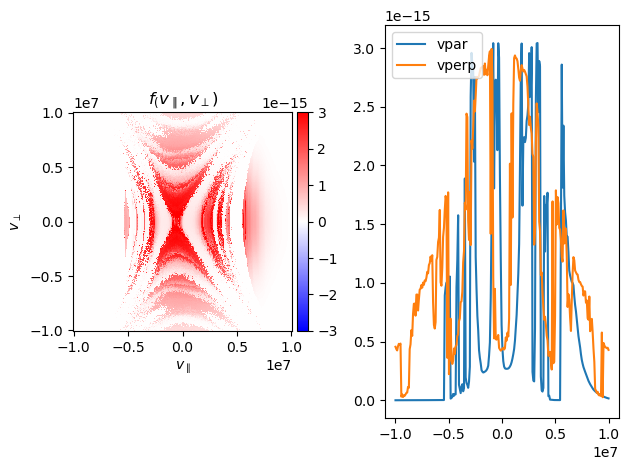

In [323]:
# Note He et al. ( https://doi.org/10.3847/1538-4357/ab9174 ) claim Tpar > Tperp due to dissipation of turbulence... could this just be adiabatic?  
# For instance: "In contrast, the electrons exhibit remarkable thermal anisotropy with Te_par > Te_perp at most times."

# See Tran & Sironi (2024) for electron simulations at a shock  --- very similar to what I'm trying to do
# "Electron Heating in 2D Particle-in-cell Simulations of Quasi-perpendicular Low-beta Shocks"
# Tran & Sironi wrote another very similar paper in 2020
# see also Sironi & Tran 2024 for another application

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


f = d['f']; vpar = d['vpar']; vperp = d['vperp']; x_f = d['x_f']; v_f = d['v_f']
r_f = np.linalg.norm(x_f, axis=-1)
r_f_mask = (r_f < 17*R_EARTH) # | (r_f > 28*R_EARTH)
f_masked = deepcopy(f)
f_masked[r_f_mask] = -1e-15

filename = d['filename']; x = d['x']; v =d['v']

fig, ax = plt.subplots(1,2)

im = ax[0].pcolormesh(vpar, vperp, f_masked,
                   cmap='bwr', shading='auto', vmin=-3e-15, vmax=3e-15)
ax[0].set_xlabel(r'$v_\parallel$')
ax[0].set_ylabel(r'$v_\perp$')
ax[0].set_title(r'$f_(v_\parallel, v_\perp)$')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mycbar = fig.colorbar(im, cax=cax, orientation='vertical')

ax[1].plot(vpar[:,nv//2], f_masked[:,nv//2], label = 'vpar')
ax[1].plot(vperp[nv//2,:], f_masked[nv//2,:], label = 'vperp')
ax[1].legend()
ax[0].set_aspect('equal')
plt.tight_layout()
plt.show()
#mycbar = ax.figure.colorbar(im)


In [324]:
x_f.shape
#x[0][0].shape


(256, 256, 3)

In [325]:

ni = f.shape[0]
nj = f.shape[1]
v_i_mag = np.zeros(f.shape)
v_f_mag = np.zeros(f.shape)
x_i = np.zeros(x_f.shape)

for i in range(ni):
    for j in range(nj):
        v_i_mag[i, j] = np.linalg.norm(v[i][j][0,:])
        v_f_mag[i, j] = np.linalg.norm(v_f[i,j,:])
        x_i[i,j,:] = x[i][j][0,:]
#v_i_mag = np.sqrt(vpar**2 + vperp**2)


energy_i = 0.5 * 9.1e-31 * v_i_mag**2 / 1.6e-19    # eV
energy_f = 0.5 * 9.1e-31 * v_f_mag**2 / 1.6e-19    # eV
energy_f

array([[775.34801477, 762.36276926, 766.79402651, ..., 789.4125174 ,
        786.75523018, 762.0879915 ],
       [794.57518377, 775.09496889, 742.57057728, ..., 736.55012969,
        769.65334013, 756.65233235],
       [742.46988712, 737.04268458, 781.39773473, ..., 768.80660055,
        770.81490774, 766.13267613],
       ...,
       [431.76996663, 427.79002773, 426.75100523, ..., 435.87187664,
        435.8665722 , 435.40714588],
       [458.52259288, 435.28214035, 431.0626472 , ..., 448.12858   ,
        457.34467686, 482.78147361],
       [479.1064166 , 457.5246572 , 450.37803678, ..., 456.17000074,
        490.78088367, 459.44660126]])

In [326]:
(energy_f - energy_i)[0,:]

array([207.03793117, 198.49528288, 207.33415081, 218.49326302,
       188.90710588, 220.99428   , 207.35026884, 224.93398514,
       193.5535277 , 221.36709813, 231.29191839, 197.84753921,
       201.91847259, 193.35353861, 196.32915625, 220.21371127,
       196.55666366, 196.14700152, 197.07394378, 230.78794919,
       200.63687002, 223.00534205, 220.56130748, 205.77089225,
       202.80159028, 236.1078225 , 220.89222652, 213.62174704,
       235.1313651 , 208.47900653, 228.84874462, 220.0572553 ,
       234.77417857, 208.04940039, 225.72267785, 231.40976829,
       210.78379225, 213.32262182, 212.73046269, 240.00488711,
       211.98331511, 215.65023296, 239.62718411, 218.82487284,
       242.7050368 , 243.62799635, 226.67413451, 242.67028041,
       240.67920411, 216.36541512, 236.04813875, 218.54712125,
       219.86982494, 240.51085526, 224.74829942, 237.557998  ,
       226.19270128, 244.70793393, 246.5908506 , 232.65282822,
       242.67120909, 242.03811888, 231.43013021, 230.88

In [327]:
x_f[3,5,:] / 6.371e6

array([ 1.01385565e+01, -2.67121109e-02, -3.00336915e+01])

In [328]:
print(vperp[0,:])
print(vpar[0,:])

[-10000000.          -9921568.62745098  -9843137.25490196
  -9764705.88235294  -9686274.50980392  -9607843.1372549
  -9529411.76470588  -9450980.39215686  -9372549.01960784
  -9294117.64705882  -9215686.2745098   -9137254.90196078
  -9058823.52941176  -8980392.15686274  -8901960.78431372
  -8823529.4117647   -8745098.03921568  -8666666.66666666
  -8588235.29411764  -8509803.92156862  -8431372.5490196
  -8352941.17647059  -8274509.80392157  -8196078.43137255
  -8117647.05882353  -8039215.68627451  -7960784.31372549
  -7882352.94117647  -7803921.56862745  -7725490.19607843
  -7647058.82352941  -7568627.45098039  -7490196.07843137
  -7411764.70588235  -7333333.33333333  -7254901.96078431
  -7176470.58823529  -7098039.21568627  -7019607.84313725
  -6941176.47058823  -6862745.09803921  -6784313.72549019
  -6705882.35294117  -6627450.98039215  -6549019.60784313
  -6470588.23529411  -6392156.86274509  -6313725.49019607
  -6235294.11764705  -6156862.74509803  -6078431.37254901
  -5999999.99999

In [329]:
energy_i

array([[568.31008359, 563.86748638, 559.4598757 , ..., 559.63402574,
        564.04302406, 568.48700893],
       [563.87009985, 559.42750263, 555.01989196, ..., 555.19404199,
        559.60304032, 564.04702518],
       [559.46510265, 555.02250543, 550.61489476, ..., 550.78904479,
        555.19804311, 559.64202798],
       ...,
       [560.29523417, 555.85263695, 551.44502628, ..., 551.61917631,
        556.02817464, 560.4721595 ],
       [564.70684596, 560.26424875, 555.85663807, ..., 556.03078811,
        560.43978643, 564.8837713 ],
       [569.1534443 , 564.71084709, 560.30323641, ..., 560.47738645,
        564.88638477, 569.33036964]])

Text(0, 0.5, 'final energy')

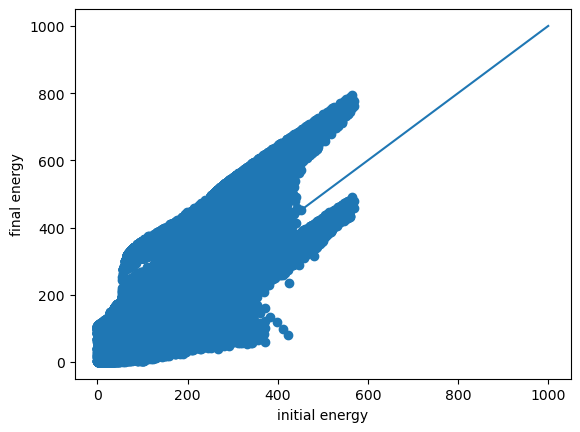

In [330]:
plt.scatter(energy_i, energy_f)
plt.plot([0,1000], [0,1000])
plt.xlabel('initial energy')
plt.ylabel('final energy')


In [331]:
# calculate the electric potential in the solar wind region
filename = get_filename(run, fileIndex)


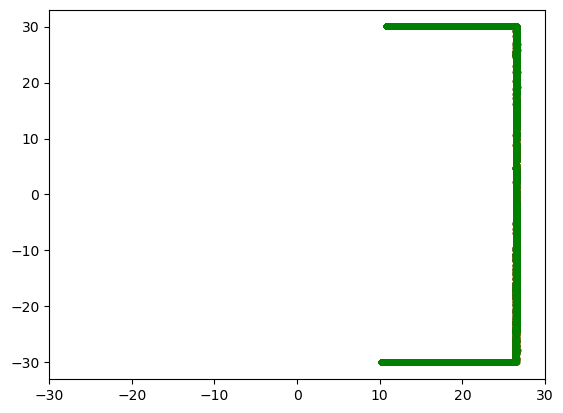

array([[-30.03367171, -30.03369487, -30.03366658, ..., -30.03364381,
        -30.03364054, -30.03369823],
       [-30.03365852, -30.0336609 , -30.03363156, ..., -30.03363917,
        -30.03369614, -30.03368119],
       [-30.03365581, -30.03361965, -30.03361863, ..., -30.03363865,
        -30.03368228, -30.03361761],
       ...,
       [ 30.03362659,  30.03363226,  30.03362119, ...,  30.03360776,
         30.03364511,  30.03363622],
       [ 30.03368621,  30.03364067,  30.03360796, ...,  30.03363967,
         30.03366496,  30.03361314],
       [ 30.03364661,  30.03365186,  30.03365664, ...,  30.03365587,
         30.03362841,  30.03365412]])

In [332]:

# maybe this only works when run with sbatch
# the idea is to plot the magnetosphere, and the initial and final points 
'''
import pytools as pt
ax = plt.gca()
pt.plot.plot_colormap3dslice(filename=filename,var='proton/vg_rho', boxre=[-20, 20, -20, 20], normal ='z', run=run,
                             colormap='plasma',step=fileIndex,outputdir='/wrk-vakka/users/horakons/carrington/plots/{}/ptest/'.format(run),
                             outputfile='vg_rho_particle_trace_{}_{}.png'.format(run, str(fileIndex).zfill(5)),
                             Earth=1, streamlines='vg_b_vol', streamlinedensity=1, streamlinecolor = 'white', cutpointre=0, axes = ax, scale=1, useimshow=True)
'''

r_f_mask3 = np.repeat(r_f_mask[:,:,None], 3, axis=2)
x_f_mask_x = deepcopy(x_f[:,:,0])
x_f_mask_x[r_f_mask] = None
x_f_mask_y = deepcopy(x_f[:,:,1])
x_f_mask_y[r_f_mask] = None
x_f_mask_z = deepcopy(x_f[:,:,2])
x_f_mask_z[r_f_mask] = None



#plt.scatter(x_f[:,:,0]/R_EARTH, x_f[:,:,1]/R_EARTH)   # x-y
plt.scatter(x_f[:,:,0]/R_EARTH, x_f[:,:,2]/R_EARTH, s =10, color = 'red')  # x-z
plt.scatter(x_f_mask_x/R_EARTH, x_f_mask_z/R_EARTH, s =10, color = 'green')  # x-z

plt.xlim([-30,30])

plt.show()
x_f[:,:,2]/R_EARTH

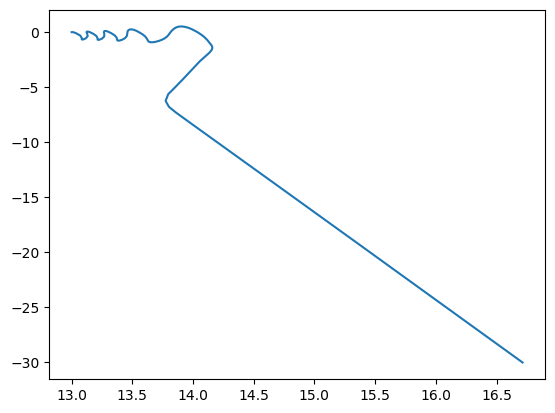

In [333]:
# plot trajectory of 1 particle in physical space
i = nv//2 +10
j = nv//2 +10
#t_inds = range(50)   
t_inds = range(d['t'].size)  # 100

#plt.plot(x[i][j][:,0]/R_EARTH, x[i][j][:,1]/R_EARTH)  # x-y
#plt.plot(x[i][j][0:100,0]/R_EARTH, x[i][j][0:100,2]/R_EARTH)  # x-z   (to show larmor motion)
plt.plot(x[i][j][t_inds,0]/R_EARTH, x[i][j][t_inds,2]/R_EARTH)

#plt.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,2]/R_EARTH)  # y-z

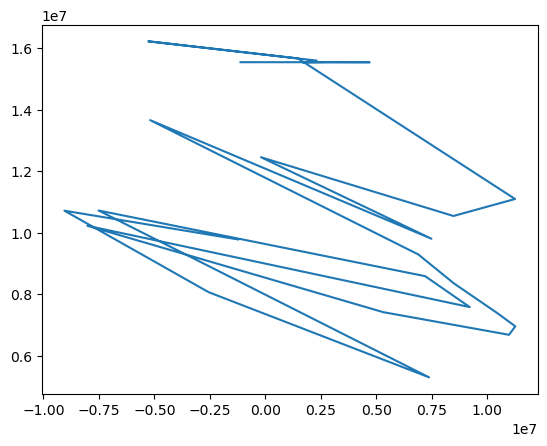

In [334]:
# plot trajectory of 1 particle in velocity space
i = 0#nv//2 +1
j = 0#nv//2 +1
#t_inds = range(50)   
t_inds = range(d['t'].size)  # 100

#plt.plot(v[i][j][:,0], v[i][j][:,1])  # x-y
plt.plot(v[i][j][t_inds,0], v[i][j][t_inds,2])
#plt.plot(v[i][j][:,1], v[i][j][:,2])  # y-z

Text(0.5, 1.0, 'Backwards trajectories starting at [13.  0.  0.] (nonlocality)')

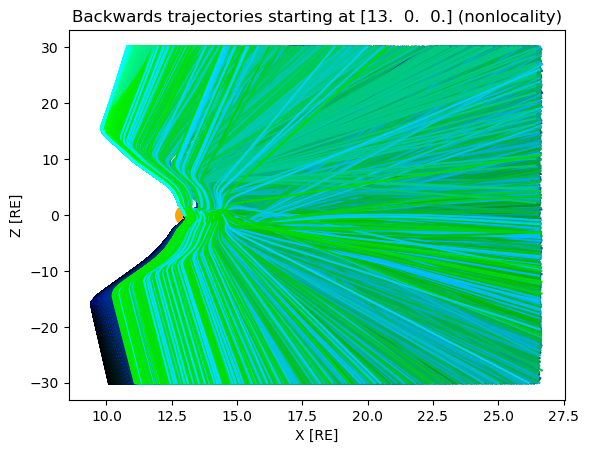

In [335]:

for i in range(nv):
    for j in range(nv):
        # ALL POSITIONS:
        #plt.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,1]/R_EARTH)  # x-y
        plt.plot(x[i][j][:,0]/R_EARTH, x[i][j][:,2]/R_EARTH, color = (0, i/nv, j/nv))  # x-z
        #plt.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,2]/R_EARTH)  # y-z
        # FINAL POSITION
        #plt.scatter(x[i][j][-1,0]/R_EARTH, x[i][j][-1,2]/R_EARTH, color = (0, i/nv, j/nv))  # x-z



plt.scatter(x[i][j][0,0]/R_EARTH, x[i][j][0,2]/R_EARTH, color = 'orange', s =200)
plt.xlabel('X [RE]')
plt.ylabel('Z [RE]')
#plt.xlim([12.5,13.5])


plt.title('Backwards trajectories starting at {} (nonlocality)'.format(x[0][0][0,:]/R_EARTH))


In [336]:

def phi_gradP(x, vlsvReader, n0 = 1e6):
    '''
    Inputs:
     x: 3-element coordinate vector or list
     vlsvReader: vlsvReader object

     PhiGradPe returns the potential Phi based on the density.
     Note when electrons follow adiabatic equation of state (EOS)
     grad Pe field is a potential field.
     Initial electron parameters (n0, T0) that set the EOS
     are found in .cfg file. But this function works for EGL, EGI, FHA

     Note: in EGL (and FHA?) n0=1e6 at early times and n0 = 4e6 at the end
    '''    
    elementalcharge = 1.6021773e-19
    kb = 1.38065e-23
    n = vlsvReader.read_interpolated_variable('proton/vg_rho', x)
    gamma = 5. / 3.
    T0 = kb * 5e5         # EGI, EGL [Joules]
    C = T0 * n0**(1. - gamma)
    return -(C / elementalcharge) * (gamma / (gamma - 1.)) * ( n**(gamma-1.) - n0**(gamma-1.) )


vlsvReader_file = get_vlsvfile_fullpath(run, fileIndex)
import ftest as ft
vlsvReader = ft.f(vlsvReader_file)

#phi_gradP(x_f[0,1], vlsvReader)
phi_gradP([13.5*R_EARTH,0,0], vlsvReader, n0 = 1e6)



Found population proton


-123.89810218706876

In [337]:
def phi_ExB(x, vlsvReader, x0 = [0,0,0], v0 = [-7.5e5, 0, 0], B0 = [0, 0, -5e-9]):
    #E would be nice to read the input data with vlsvReader.get_config(), but that doesn't seem to be working for EGI/EGL
    #measure ExB potential at x, with respect to the position x0, assuming uniform v and B fields 
    E_convec = -np.cross(np.array(v0), np.array(B0))  # for EGL, in +y direction
    deltax = np.array(x) - np.array(x0)
    return -np.dot(deltax, E_convec)


phi_ExB([11.5*R_EARTH, 0.01*R_EARTH,0], vlsvReader)   # for EGL, EGI, FHA, only the y-component matters


-238.91250000000002

In [338]:
print( phi_ExB(x_f[3,3], vlsvReader) )
print( phi_gradP(x_f[3,3], vlsvReader, n0 = 1e6) )
phi_gradP(x_i[i,j], vlsvReader, n0 = 1e6) 
phi_ExB(x_i[i,j], vlsvReader) 



637.8353357962736
0.93132985367272


-0.0

In [278]:
phi1 = phi_ExB(x_f, vlsvReader)
phi1 = phi1 - phi1[4,4]   # subtract the potential of the electron with v_i = 0, assumed to be moving on an equipotential
phi2 = phi1 * 0
for i in range(nv):
    for j in range(nv):
        phi2[i,j] = phi_gradP(x_f[i,j], vlsvReader, n0 = 1e6)  - phi_gradP(x_i[i,j], vlsvReader, n0 = 1e6)    

phi_tot = phi1 + phi2    # electric potential [volts]. Note phi2 is given as diff. between locations x_f and x_i, while phi1 is given as a presumed potential wrt a reference y-location. Note the ExB leading to phi1 is not required to be a potential field

phi1[4,4]

11-May-24 15:43:21: /proj/horakons/analysator/pyVlsv/vlsvreader.py:1297: UserWarning: Interpolation across refinement levels. Results are not accurate there.
  warnings.warn("Interpolation across refinement levels. Results are not accurate there.",UserWarning)



KeyboardInterrupt: 

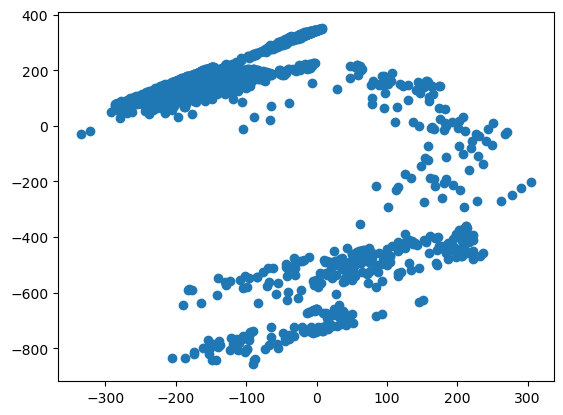

In [ ]:
delta_energy = energy_f - energy_i
plt.close()
plt.scatter(delta_energy, phi_tot)

In [ ]:
phi1
phi2

array([[134.63579075, 134.63917432, 134.63563945, ..., 134.64041255,
        134.63649405, 134.63990342],
       [134.63968997, 134.64026972, 134.63629821, ..., 134.63337705,
        134.63714773, 134.63509111],
       [134.63361204, 134.63597025, 134.63453463, ..., 134.63613014,
        134.63510282, 134.63756607],
       ...,
       [134.6412112 , 134.64386345, 134.64275947, ..., 134.64164298,
        134.64267064, 134.64357388],
       [134.64423999, 134.64375425, 134.64332077, ..., 134.64258367,
        134.64327994, 134.64343171],
       [134.64687819, 134.64688665, 134.64661923, ..., 134.64622409,
        134.64649212, 134.6465846 ]])

In [ ]:
phi_gradP(x_i[5,5], vlsvReader, n0 = 1e6)

-133.72073436284492

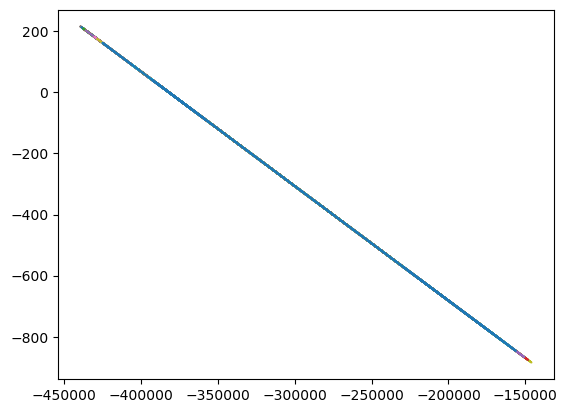

In [ ]:
plt.plot(x_f[:,:,1], phi1)
plt.show()

In [ ]:
x[0,0][106,:]/R_EARTH

array([  9.38064194,  -0.06542267, -30.33411135])

(array([ 35,  36,  37, ..., 227, 228, 231]),
 array([250, 251, 248, ..., 253,   1,   1]))

In [ ]:
np.where(r_f_mask == True)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
r_f/R_EARTH

array([[32.05181395, 32.25279673, 32.21924974, ..., 31.84510904,
        31.86111521, 31.75472491],
       [31.88719425, 31.80140386, 31.69550283, ..., 32.68527866,
        32.56672019, 32.46074906],
       [32.72186418, 32.63183646, 32.79551005, ..., 32.29423689,
        32.43019576, 32.36541009],
       ...,
       [32.14800013, 32.04031126, 32.26320041, ..., 32.20447901,
        32.3206149 , 32.22190526],
       [32.05837028, 32.03875875, 31.98962376, ..., 32.36940596,
        32.34887273, 32.46444177],
       [32.54644214, 32.37701034, 32.24269081, ..., 32.03592343,
        32.09399462, 32.78687571]])

In [ ]:
f[r_f_mask]

array([], dtype=float64)